## Preparing data

### Setting up the environment

```bash
conda create -n bulk -c conda-forge -c bioconda -c defaults star subread python=3.8 bioconductor-deseq2 bioconductor-apeglm rpy2 -y

conda activate bulk
pip install git+https://github.com/LouisFaure/deseq2py.git
pip install git+https://github.com/LouisFaure/bulktools-py.git
```

### Downloading genome and annotation
```bash
wget https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M27/gencode.vM27.annotation.gtf.gz
wget https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M28/GRCm39.primary_assembly.genome.fa.gz
gunzip *.gz
```

### Making STAR reference genome
```bash
STAR --runMode genomeGenerate --runThreadN 40 --genomeDir GRCm39_vM27_ML --genomeFastaFiles GRCm39.primary_assembly.genome.fa --sjdbGTFfile gencode.vM27.annotation.gtf --sjdbOverhang 50

```


### Do the counting

```bash
bt -s GRCm39_vM27_ML -g gencode.vM27.annotation.gtf -n 20
```

## Perform the analysis

### Load libraries

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Arial']
sc.set_figure_params()


### Load and prepare count data

In [3]:
adata_bulk=sc.read("adata_bulk_star.h5ad")
adata_bulk.obs["exp"]=adata_bulk.obs_names
adata_bulk.obs["condition"]=[''.join([i for i in s if not i.isdigit()]) for s in adata_bulk.obs_names]
adata_bulk.obs["condition"]=adata_bulk.obs["condition"].astype("category")


In [4]:
adata_bulk.obs["condition"]=adata_bulk.obs["condition"].cat.reorder_categories(["M","C","CC"])

In [5]:
adata_bulk=adata_bulk[adata_bulk.obs["condition"]!="C"]

In [6]:
adata_bulk.obs.condition=adata_bulk.obs.condition.cat.rename_categories(["Mutant","Control"])

Trying to set attribute `.obs` of view, copying.


### Running DESeq2 pipeline

In [7]:
import deseq2py as deseq2

In [8]:
deseq2.tl.run(adata_bulk,formula="~ condition")

Running DESeq2
    done (0:00:17) --> added
    .layers['normalized'] normalized count matrix.
    .uns['dds'] DESeq2 R object.
    .uns['Formula'] formula used for design parameter.


### Performing PCA

In [9]:
deseq2.tl.vst(adata_bulk)

Obtaining vsd
    done (0:00:00) --> added
    .layers['vsd'] variance stabilized count matrix.


In [10]:
deseq2.tl.pca(adata_bulk)

Obtaining PCA
    on highly variable genes using vsd matrix
    done (0:00:00) --> added
    .var['vsd_std'] variance of genes calculated from vsd matrix.
    .var['highly_variable'] genes considered as highly variable.
    .obsm['X_pca'] PCA results.
    .uns['pca'] PCA additional results.


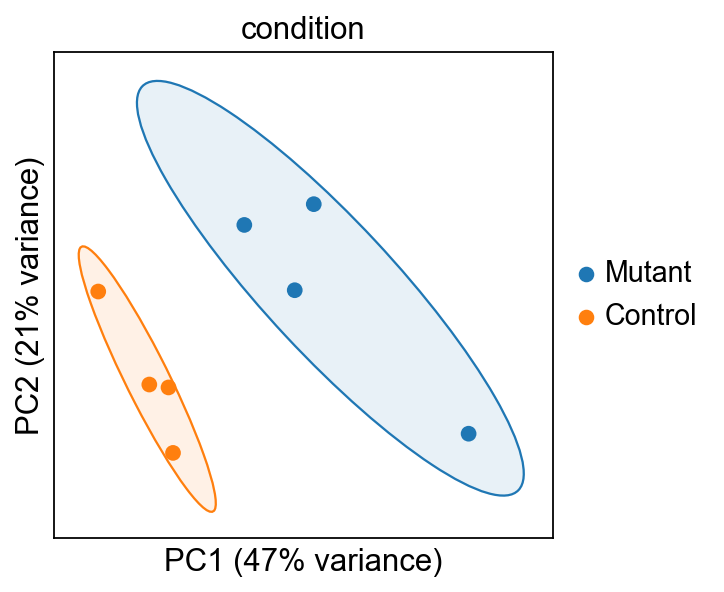

In [11]:
deseq2.pl.pca(adata_bulk,color="condition",
              show_ellipses=True,ellipse_std=2,save=".pdf")

## Save the results

In [24]:
deseq2.tl.save(adata_bulk,"adata_deseq2")

Saving results
    done --> saved
    adata_deseq2.h5ad: anndata file containing counts matrices, pca and DE results.
    adata_deseq2.rds: R object of the DESeqDataSet.
